# Offshore Oil and Gas Energy System Operation (OOGESO)
# Test platform v1 (Nov 2020)
Representing a hypothetical, but realistic Norwegian offshore oil and gas platform

* wellstream: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day = 4300 Sm3oe/day
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 

Gas oil ratio and water cut (standard units):
* GOR = 4.3 mill/8640 = 497
* WC = 12960/(12960+8640) = 0.6


In [3]:
%load_ext autoreload
%autoreload 2
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)
import oogeso
from oogeso.io import file_io
from oogeso.plotting_utils import plots
from oogeso.core.util import create_timeseriesdata
#import matplotlib.pyplot as plt
import IPython.display
#import numpy as np
import pandas as pd
import logging
import pprint
import ipywidgets
import cloudpickle
import plotly.express as px
import pyomo.environ as pyo
from dataclasses import asdict

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel('INFO')
#print("Using Oogeso version {}".format(oogeso.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read input data

In [29]:
#case='1' # base case without wind
case='1a' # case with 24 MW wind capacity
#case='1b' # case with 24 MW wind capacity AND 4 MW, 4 MWh battery
#timerange=[0,12*24*7] #one week (with 5 min timestep)
timerange=[0,40] # testing
outpath = "result/"
pickle_save='{}case{}.pkl'.format(outpath,case)
plots.plotter="plotly"

data = file_io.read_data_from_yaml('testplatform.yaml')
timeseries = file_io.read_profiles_from_csv(
    filename_nowcasts="testplatform_profiles_nowcasts.csv",
    filename_forecasts="testplatform_profiles_forecasts.csv")
profiles = create_timeseriesdata(
    df_forecast= timeseries["forecast"],
    df_nowcast=timeseries["nowcast"],
    time_start=None,time_end=None,
    timestep_minutes=5,
    resample_method="linear")
data.profiles = profiles

#data['paramParameters']['planning_horizon']=12

if case=='1':
    wind_P_max=0 # no wind
elif case=='1a':
    wind_P_max=8*3 # 3x8 MW, as agreed with ABB
elif case=='1b':
    wind_P_max=8*3 # 3x8 MW, as agreed with ABB

gts = ['Gen1','Gen2','Gen3']
wells = ['wellL1', 'wellL2']
for dev in data.devices:
    if dev.id in gts:
        dev.start_stop.is_on_init = True
    if dev.id == "wind":
        dev.flow_max = wind_P_max
    if dev.id in wells:
        # fixed production - not allowed to reduce:
        dev.flow_min = dev.flow_max

#optimiser = oogeso.Optimiser(data)
simulator = oogeso.Simulator(data)

store_duals = None #{'elcost':{'constr': 'constr_PQ_load_Pmin', 'indx':[None]}}

INFO:root:profiles in use: ['waterinj', 'oilgas', 'curve_wind']
INFO:root:Using objective function  exportRevenue
INFO:root:No emission_rate_max limit specified
INFO:root:No emission_intensity_max limit specified
INFO:root:No el_backup_margin limit specified


In [30]:
simulator.optimiser.pyomo_instance.dual.pprint()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key : Value


In [6]:
#optimiser.pyomo_instance.paramProfiles.pprint() # all 1 before update, from profile after
#optimiser.pyomo_instance.paramDeviceIsOnInitially.pprint() # all 1 before and after update
#optimiser.pyomo_instance.paramDevicePrepTimestepsInitially.pprint() # all 0 before and after update
#optimiser.pyomo_instance.paramDevicePowerInitially.pprint() # unchanged before/after

### Inspect input data

In [7]:
@ipywidgets.interact(datagroup=['','devices','nodes','edges','carriers','parameters'])
def showdata(datagroup):
    pprint.pprint(asdict(data)[datagroup],indent=1) if datagroup!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'devices', 'nodes', 'edges', 'carriers', …

In [8]:
yy=['']+list(simulator.optimiser.pyomo_instance.component_objects(oogeso.optimiser.pyo.Constraint, active=True))
@ipywidgets.interact(constraint=yy)
def showdata(constraint):
    pprint.pprint(constraint.pprint(),width=1) if constraint!='' else print('')

interactive(children=(Dropdown(description='constraint', options=('', <pyomo.core.base.constraint.IndexedConst…

In [9]:
# View profiles (entire available time windows)
#plots.plotProfiles(simulator.profiles,filename=None)

In [10]:
dev=simulator.optimiser.all_devices['Gen1'].dev_data
fuelA = dev.fuel_A
fuelB = dev.fuel_B
Pmax = dev.flow_max
#plots.plotGasTurbineEfficiency(filename='gasturbine_Gen1.png',fuelA=fuelA,fuelB=fuelB,Pmax=Pmax)

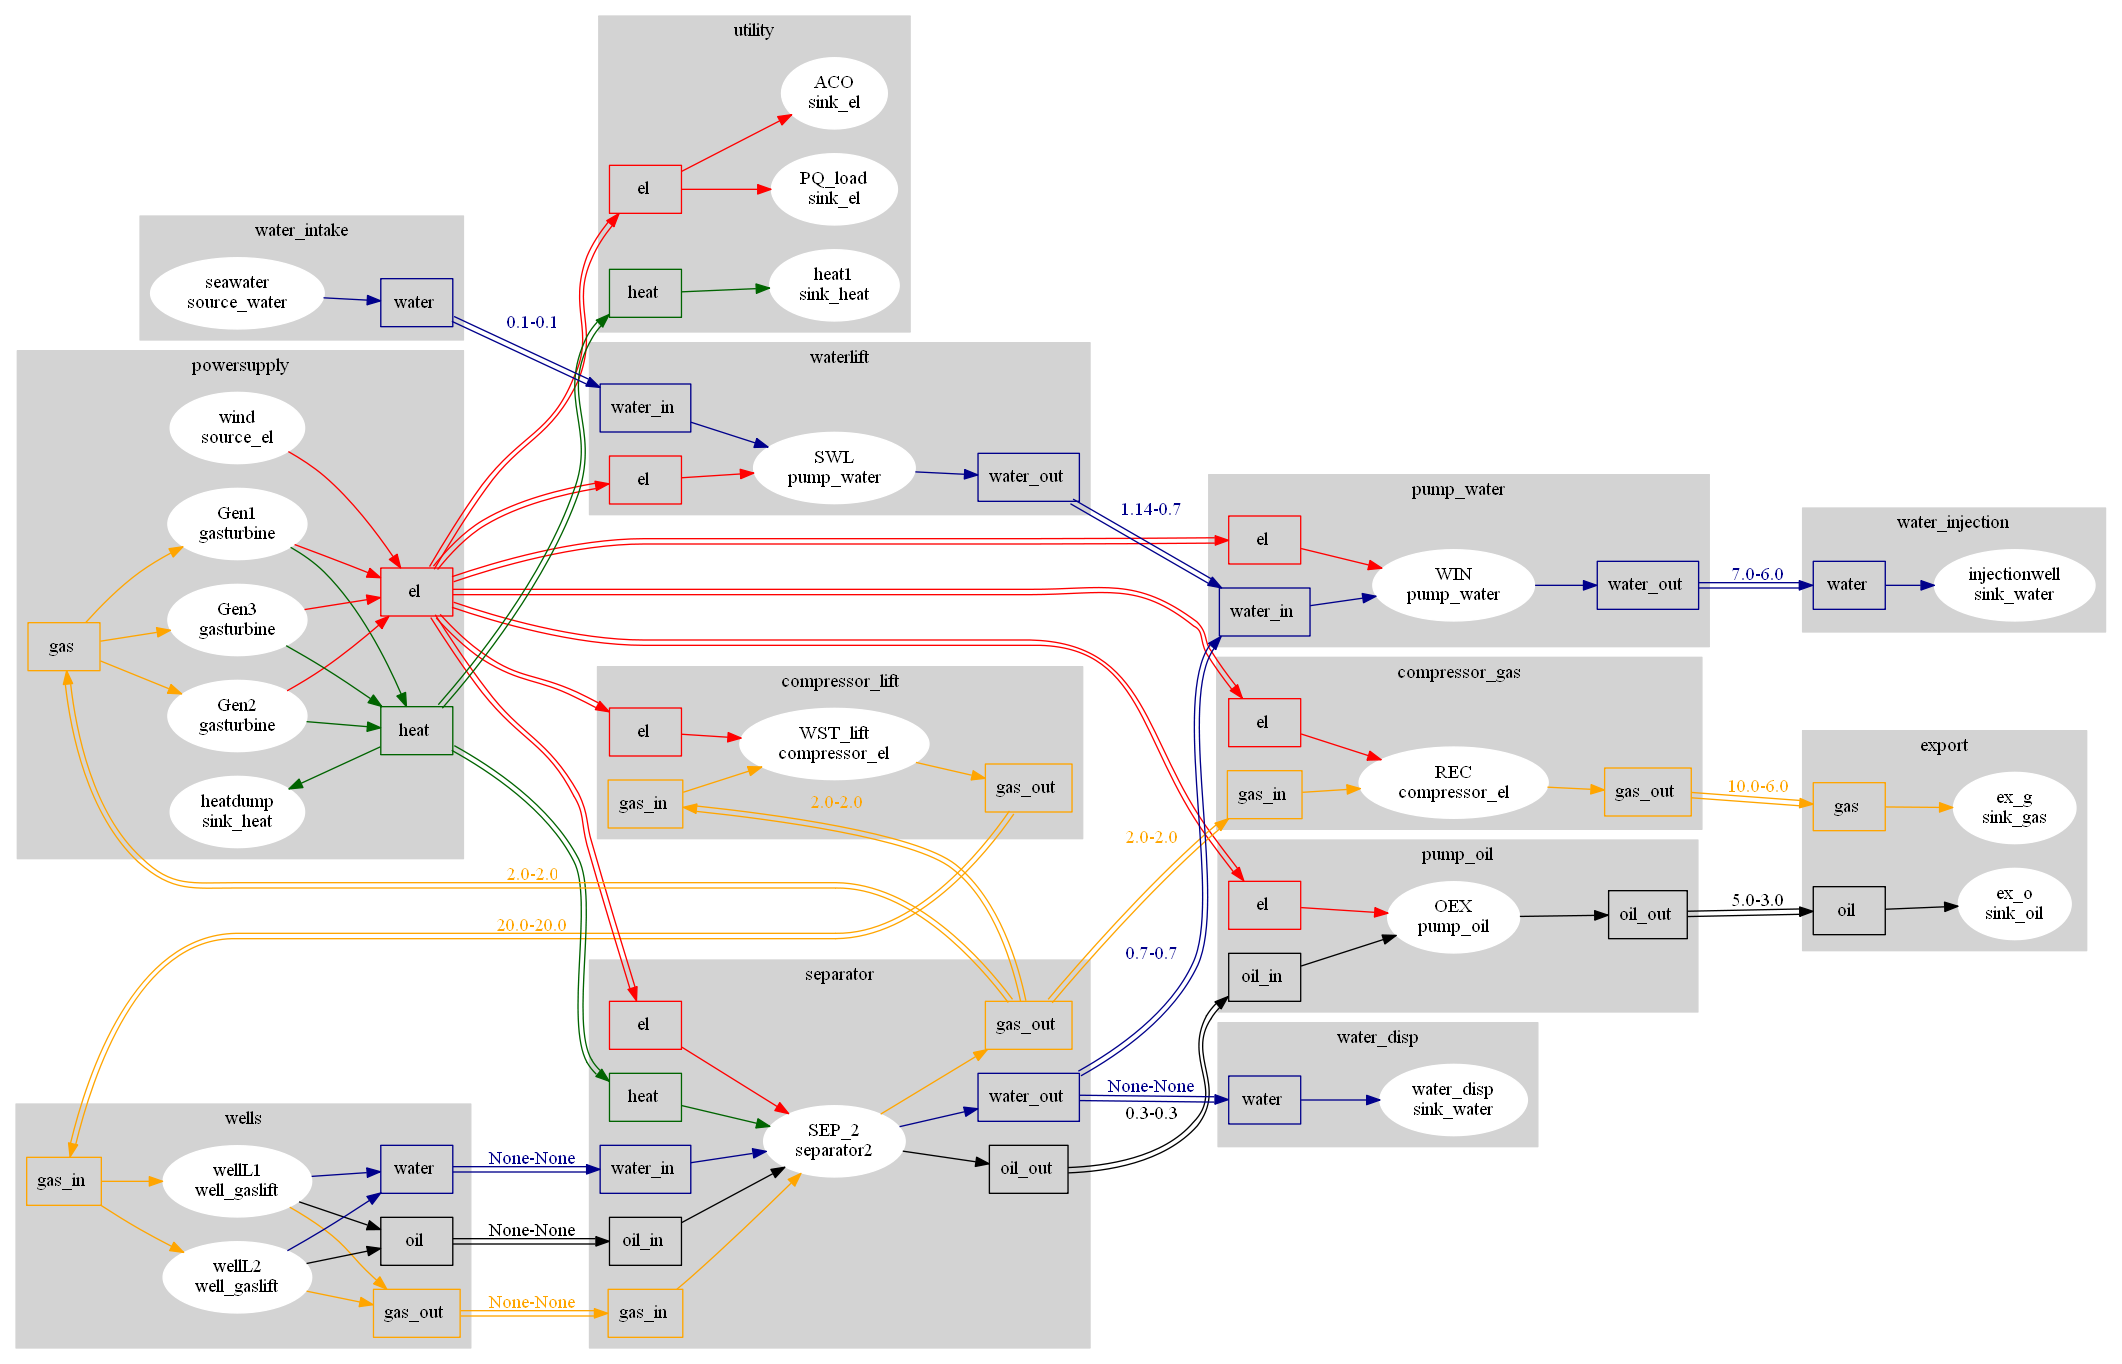

In [11]:
# View energy system
dotG=plots.plotNetwork(simulator,timestep=None,filename=None)
IPython.display.Image(dotG.create_png()) #scales automatically to page width

### Some checks on input data

In [12]:
print("flow per pipe = {:.4} Sm3/s".format(50/15))
flow1=oogeso.networks.network_edge.darcy_weissbach_Q(p1=6.164,p2=6,f=0.001,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow2=oogeso.networks.network_edge.darcy_weissbach_Q(p1=6.164,p2=4,f=0.0136,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
flow3=oogeso.networks.network_edge.darcy_weissbach_Q(p1=7,p2=4,f=0.0189,rho=5.63,
    diameter_mm=200,length_km=1,height_difference_m=100)
print("flow1 (6.164->6): {:.4}".format(flow1))
print("flow2 (6.164->4): {:.4}".format(flow2))
print("flow3 (7->4):     {:.4}".format(flow3))

flow per pipe = 3.333 Sm3/s
flow1 (6.164->6): 3.333
flow2 (6.164->4): 3.336
flow3 (7->4):     3.333


In [13]:
# Water pipe pressure drop ('w3')
#mc.instance.paramEdge['w3']['num_pipes']=15
#mc.instance.paramEdge['w1']['diameter_mm']=200
edge = simulator.optimiser.all_edges['w1']
print(edge.edge_data)
print("=> Pressure out={:.4} MPa".format(edge.compute_edge_pressuredrop(
    p1=1.14,Q=1.15/3,linear=False)))


EdgeWaterData(id='w1', node_from='waterlift', node_to='pump_water', length_km=0.01, flow_max=None, bidirectional=False, include=1, carrier='water', pressure_from=1.14, pressure_to=0.7, diameter_mm=200.0, temperature_K=None, height_m=40.0, num_pipes=3)
=> Pressure out=0.6981 MPa


## Solve

If the problem is infeasible, try 
* relaxing pressure deviation limits (generic value and per-node value)
* add a high cost emergency generator (that could represent load shedding) to ensure energy balance can be satisfied
* make sure excess heat/water/gas has a place to go


In [31]:
simulator.optimiser.write("testplatform.mps")
status = simulator.runSimulation(solver="gurobi",timerange=timerange,write_yaml=False,timelimit=60,store_duals=store_duals)
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(simulator._dfCO2rate.mean()))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(simulator._dfCO2intensity.mean()))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in simulator._dfExportRevenue.mean().items() if v!=0],"$/s")

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]

Mean CO2 emission rate      = 6.5 kgCO2/s
Mean CO2 emission intensity = 45.3 kgCO2/Sm3oe
Mean export revenue         = gas:193.2  oil:409.8  $/s


## Save/Load simulation results
By saving to pickle file, it easy to later open and analyse the results without having to re-run the simulation

In [116]:
# Save (pickle) - for later opening and analysis
with open(pickle_save, mode='wb') as file:
   cloudpickle.dump(mc, file)
print("Results were saved to {}".format(pickle_save))

FileNotFoundError: [Errno 2] No such file or directory: 'result/case1a.pkl'

In [117]:
# Open previously saved object (including simulation results)
#with open(pickle_save, mode='rb') as file:
#   mc = cloudpickle.load(file)

## Analyse results

In [32]:
kpi = simulator.compute_kpis(windturbines=['wind'])
kpi = pd.DataFrame.from_dict(kpi,orient="index",columns=[case])
kpi

1a
hours_simulated              3.500000e+00
kgCO2_per_year               2.057617e+08
kgCO2_per_Sm3oe              4.533988e+01
gt_fuel_sm3_per_year         8.793235e+07
elconsumption_mwh_per_year   3.584796e+05
elconsumption_avg_mw         4.092233e+01
gt_starts_per_year           0.000000e+00
gt_stops_per_year            2.502857e+03
gt_hoursrunning_per_year     1.752000e+04
wind_output_mwh_per_year     2.900276e+04
wind_curtailed_mwh_per_year  1.611663e-11

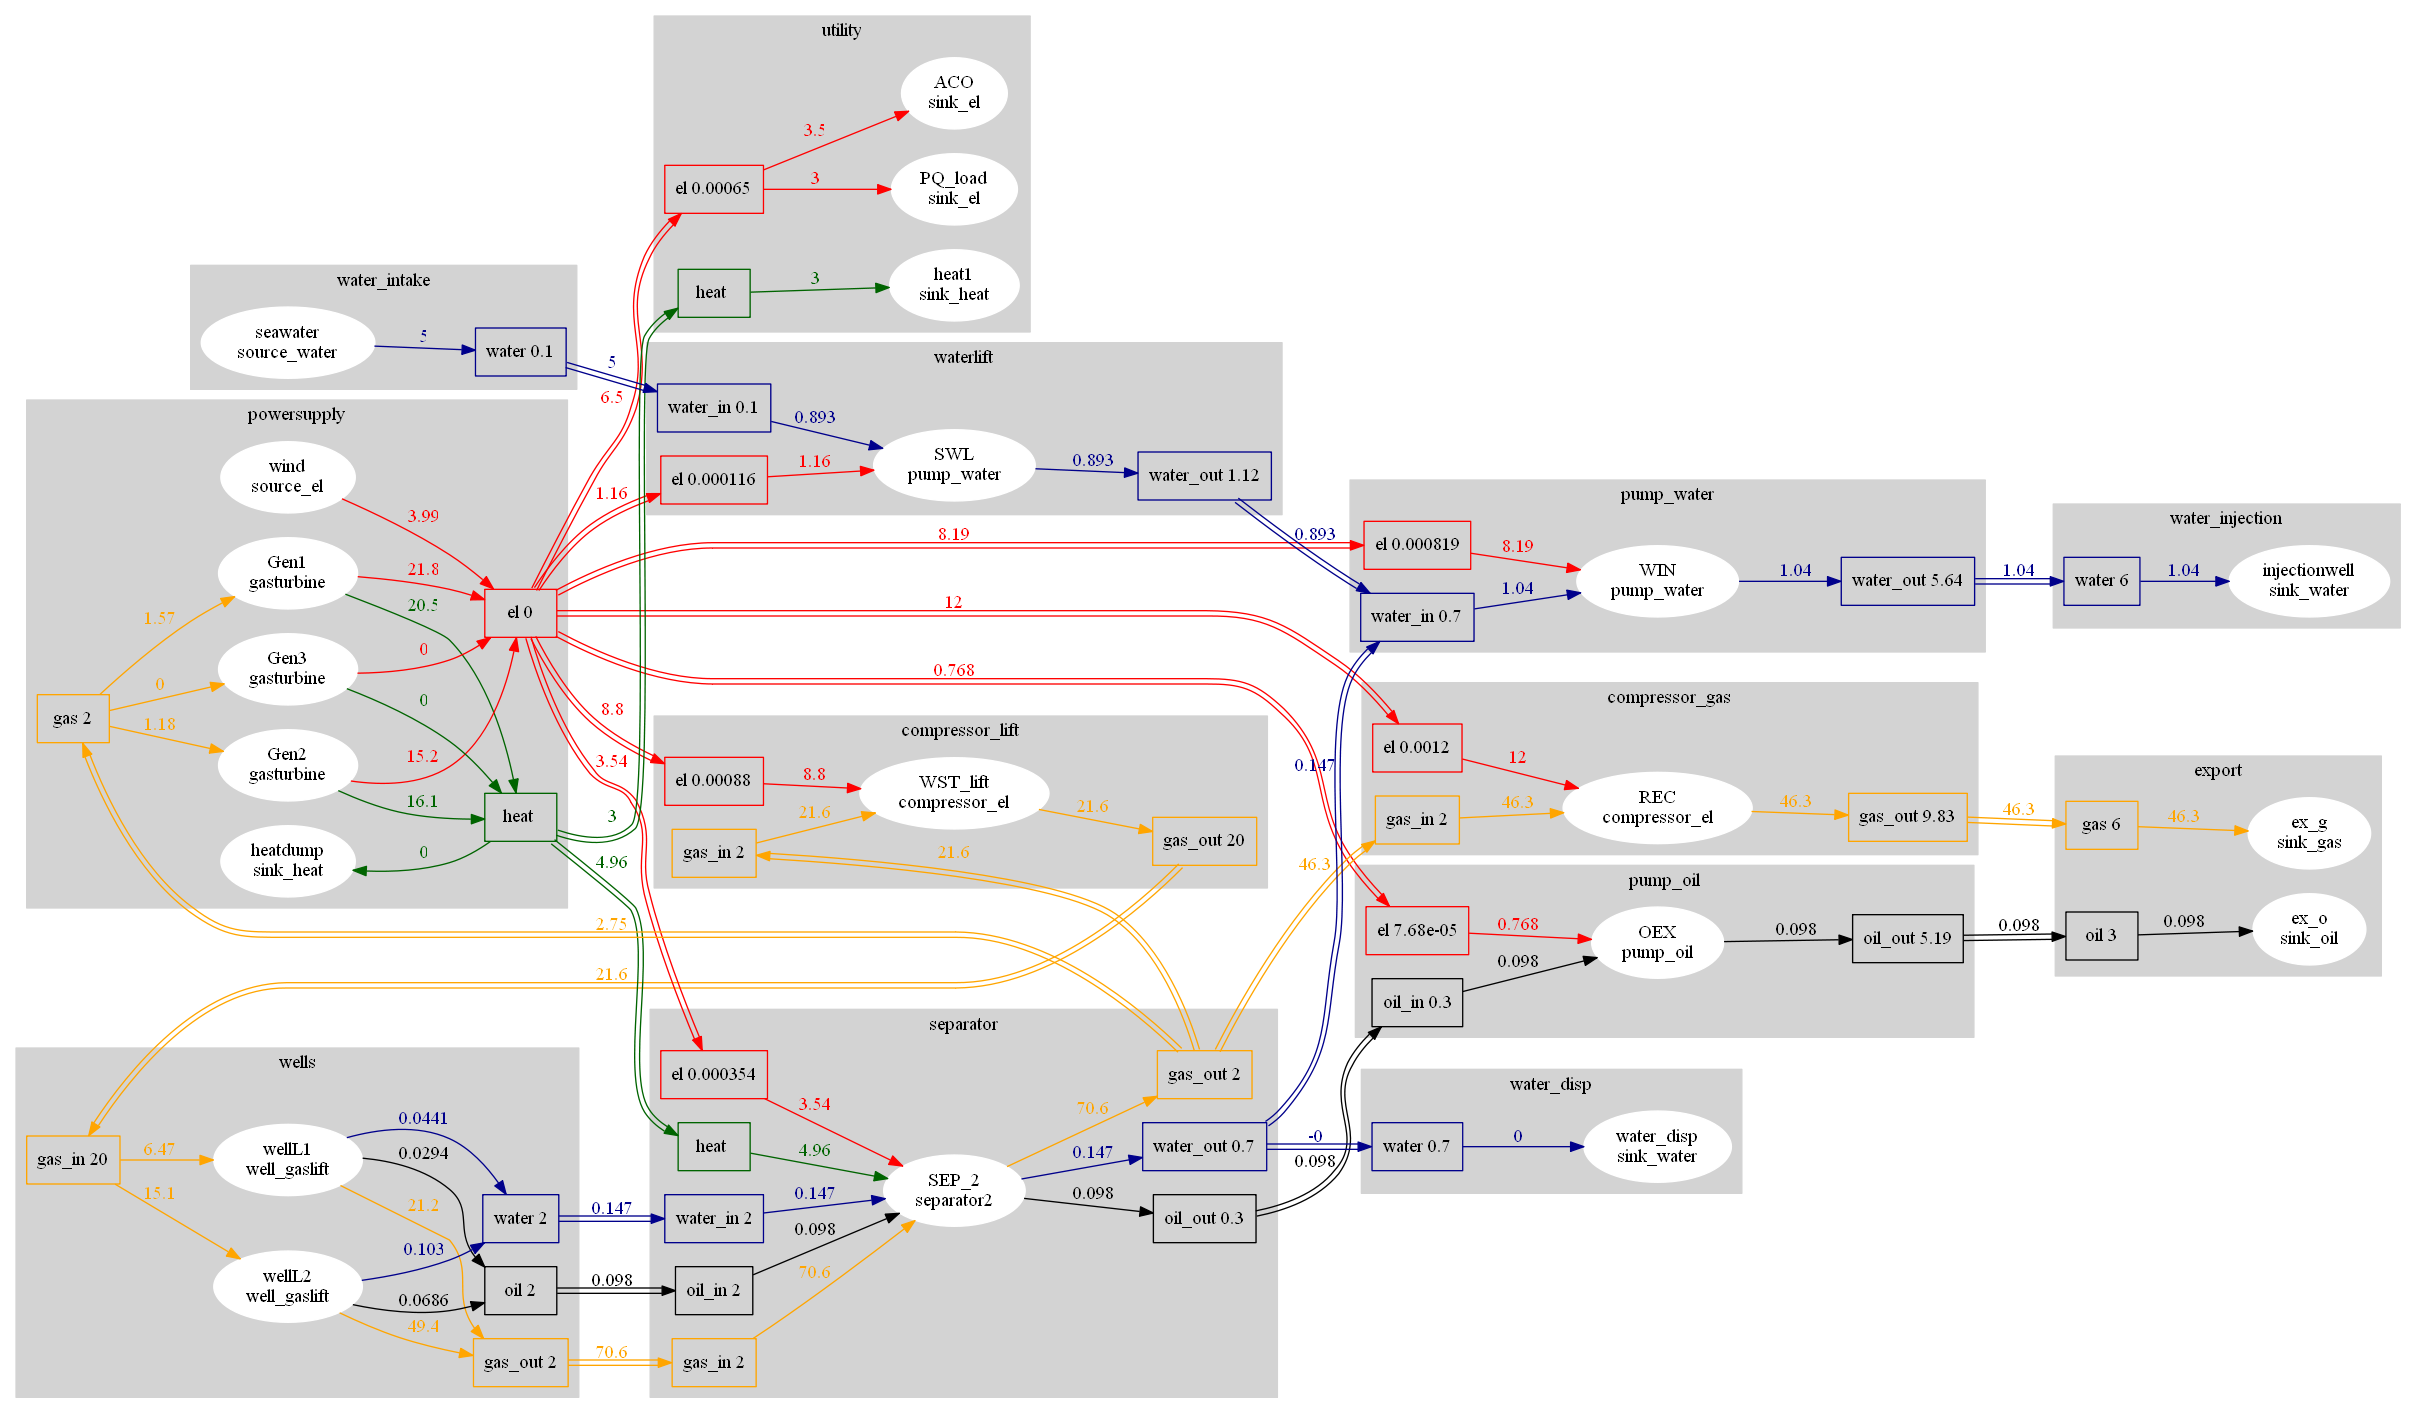

In [33]:
tstep=0
gCombined = plots.plotNetwork(simulator=simulator,timestep=tstep,numberformat="{:.3g}",filename=None)
IPython.display.Image(gCombined.create_png())

In [35]:
#simulator._dfElVoltageAngle.unstack("node")
#simulator._dfPenalty

In [36]:
print("CHECKING edge pressure drop on selected edges:")
optimiser = simulator.optimiser
print('w1: {:.5g} MPa'.format(optimiser.all_edges['w1'].compute_edge_pressuredrop(Q=1.15,p1=0.7,linear=True)))
print('w3: {:.5g} MPa'.format(optimiser.all_edges['w3'].compute_edge_pressuredrop(Q=1.3/15,p1=7,linear=False)))
print('o2: {:.5g} MPa'.format(optimiser.all_edges['o2'].compute_edge_pressuredrop(Q=0.1,p1=5,linear=True)))
print('g2: {:.5g} MPa'.format(optimiser.all_edges['g2'].compute_edge_pressuredrop(Q=48,p1=10,linear=True)))

CHECKING edge pressure drop on selected edges:
w1: 0.10778 MPa
w3: 6.1178 MPa
o2: 2.7294 MPa
g2: 5.8895 MPa


In [121]:
#mc.checkEdgePressureDrop(timestep=1,var="outer")

INFO:root:['Gen1', 'Gen2', 'Gen3']


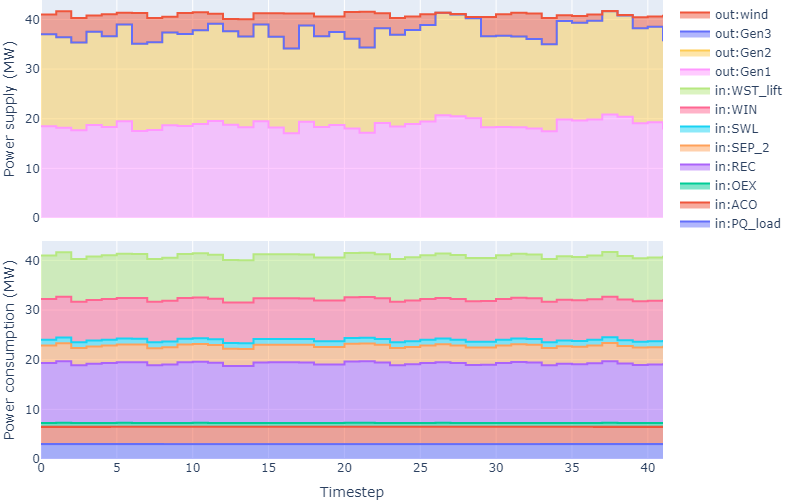

In [37]:
plots.plotter='plotly'
fig2=plots.plot_SumPowerMix(simulator,carrier="el",filename=None)
fig2.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=0,b=0))
#fig2.write_image("{}/elpowermix_{}.png".format(outpath,case))

el      heat
device                            
ACO             3.500000  0.000000
Gen1            0.000000  0.000000
Gen2            0.000000  0.000000
Gen3            0.000000  0.000000
OEX             0.766146  0.000000
PQ_load         3.000000  0.000000
REC            11.991034  0.000000
SEP_2           3.533235  4.946529
SWL             1.161279  0.000000
WIN             8.190000  0.000000
WST_lift        8.780636  0.000000
ex_g            0.000000  0.000000
ex_o            0.000000  0.000000
heat1           0.000000  3.000000
injectionwell   0.000000  0.000000
seawater        0.000000  0.000000
water_disp      0.000000  0.000000
wellL1          0.000000  0.000000
wellL2          0.000000  0.000000
wind            0.000000  0.000000

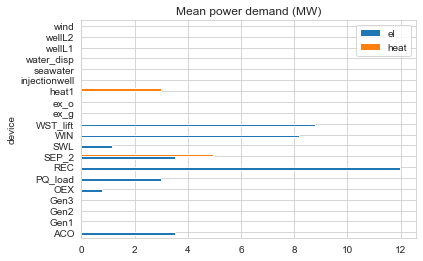

In [38]:
mean_el_demand = simulator._dfDeviceFlow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand = simulator._dfDeviceFlow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
energydemand = pd.concat({'el':mean_el_demand,'heat':mean_heat_demand},axis=1)
energydemand.drop('heatdump',inplace=True)
energydemand.plot.barh(title="Mean power demand (MW)")
energydemand

In [39]:
print("Gas flow out ot terminal:")
simulator._dfDeviceFlow.unstack('carrier')['gas'].unstack('terminal')['out'].dropna().unstack().T.mean()

Gas flow out ot terminal:


device
ACO               0.000000
Gen1              0.000000
Gen2              0.000000
Gen3              0.000000
OEX               0.000000
PQ_load           0.000000
REC              46.114593
SEP_2            70.420191
SWL               0.000000
WIN               0.000000
WST_lift         21.517280
ex_g              0.000000
ex_o              0.000000
heat1             0.000000
heatdump          0.000000
injectionwell     0.000000
seawater          0.000000
water_disp        0.000000
wellL1           21.126057
wellL2           49.294133
wind              0.000000
dtype: float64

In [40]:
well_inout=simulator._dfDeviceFlow.unstack('device')[['wellL1','wellL2']].sum(axis=1).unstack('time').mean(axis=1).unstack('terminal')
print("Net gas production = {:.5g} Sm3/s".format((well_inout['out']-well_inout['in']).sum()))
print("Gas circulated =     {:.5g} Sm3/s".format(well_inout['in'].sum()))

Net gas production = 49.147 Sm3/s
Gas circulated =     21.517 Sm3/s


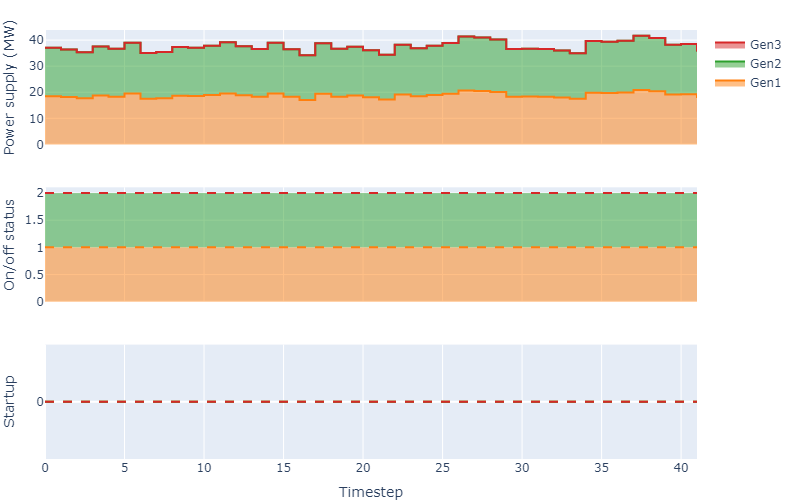

In [41]:
plots.plotter="plotly"
gts = [d for d,d_obj in optimiser.all_devices.items() if d_obj.dev_data.model=='gasturbine']
fig=plots.plot_deviceprofile(simulator=simulator,devs=gts,filename=None,includeOnOff=True,includePrep=True)
fig.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=30,b=0))

In [42]:
# Print constraint for last rolling horizon optimisation
gt='Gen2'
print("GT is on initially ={}".format(pyo.value(optimiser.pyomo_instance.paramDeviceIsOnInitially[gt])))
print("GT timesteps in startup preparation = {}".format(pyo.value(optimiser.pyomo_instance.paramDevicePrepTimestepsInitially[gt])))
for t in range(6):
    c = getattr(optimiser.pyomo_instance,"constr_{}_startstop".format(gt))
    cstr=c[t]
    print("t={}: {} = {}".format(t,cstr.body,cstr.upper))

GT is on initially =1.0
GT timesteps in startup preparation = 0
t=0: varDeviceIsOn[Gen2,0] - paramDeviceIsOnInitially[Gen2] + varDeviceStopping[Gen2,0] = 0.0
t=1: varDeviceIsOn[Gen2,1] - varDeviceIsOn[Gen2,0] + varDeviceStopping[Gen2,1] = 0.0
t=2: varDeviceIsOn[Gen2,2] - varDeviceIsOn[Gen2,1] + varDeviceStopping[Gen2,2] = 0.0
t=3: varDeviceIsOn[Gen2,3] - varDeviceIsOn[Gen2,2] + varDeviceStopping[Gen2,3] = 0.0
t=4: varDeviceIsOn[Gen2,4] - varDeviceIsOn[Gen2,3] + varDeviceStopping[Gen2,4] = 0.0
t=5: varDeviceIsOn[Gen2,5] - varDeviceIsOn[Gen2,4] + varDeviceStopping[Gen2,5] = 0.0


In [43]:
dfStartopt = pd.DataFrame()
inst=optimiser.pyomo_instance
for t in inst.setHorizon: 
    dfStartopt.loc[t,'start']=inst.varDeviceStarting['Gen2',t].value
    dfStartopt.loc[t,'prep']=inst.varDeviceIsPrep['Gen2',t].value
    dfStartopt.loc[t,'on']=inst.varDeviceIsOn['Gen2',t].value
    dfStartopt.loc[t,'stop']=inst.varDeviceStopping['Gen2',t].value
#dfStartopt

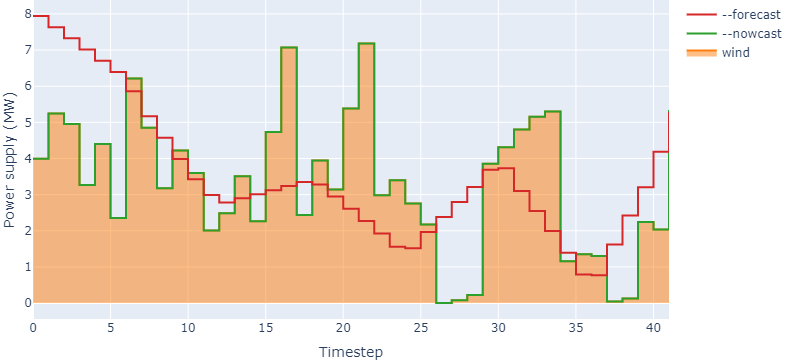

In [44]:
fig=plots.plot_deviceprofile(simulator,devs=['wind'],filename=None,includeForecasts=True)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

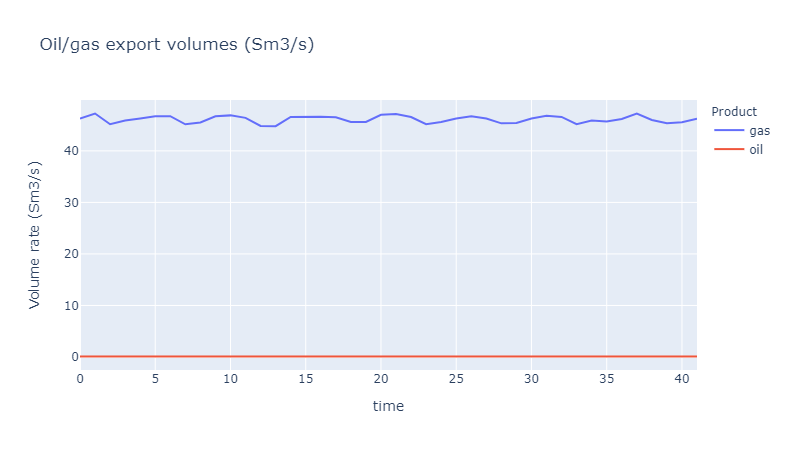

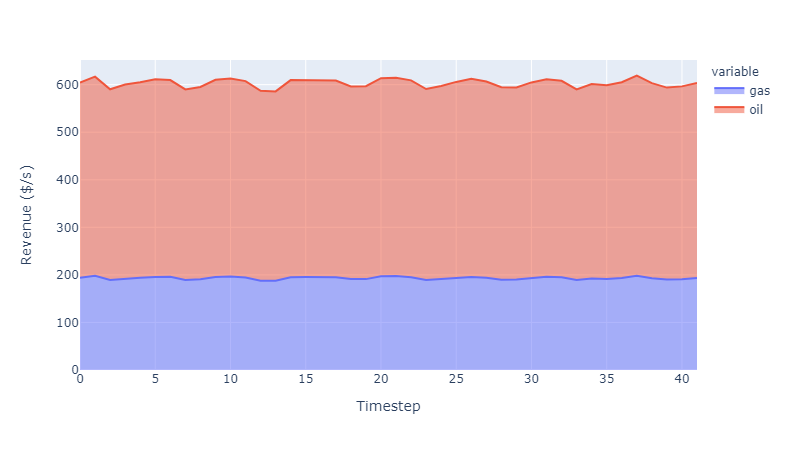

In [45]:
df=simulator._dfDeviceFlow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
df.columns=['gas','oil']
df=df.reset_index()
df = df.melt(var_name="Product",value_name="Volume rate (Sm3/s)",id_vars=('time'))
px.line(df,x="time",y="Volume rate (Sm3/s)",color="Product",title="Oil/gas export volumes (Sm3/s)").show()

plots.plot_ExportRevenue(simulator)

In [46]:
simulator.optimiser.pyomo_instance.setDevice.pprint()

setDevice : devices
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   21 : {'Gen1', 'Gen2', 'Gen3', 'wind', 'PQ_load', 'ACO', 'OEX', 'REC', 'SEP_2', 'SWL', 'WIN', 'WST_lift', 'ex_g', 'ex_o', 'heat1', 'heatdump', 'injectionwell', 'seawater', 'water_disp', 'wellL1', 'wellL2'}


In [47]:
plots.plotter="plotly"
if 'battery' in simulator.optimiser.pyomo_instance.setDevice:
    fig=plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()
    oogeso.milp_plot.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

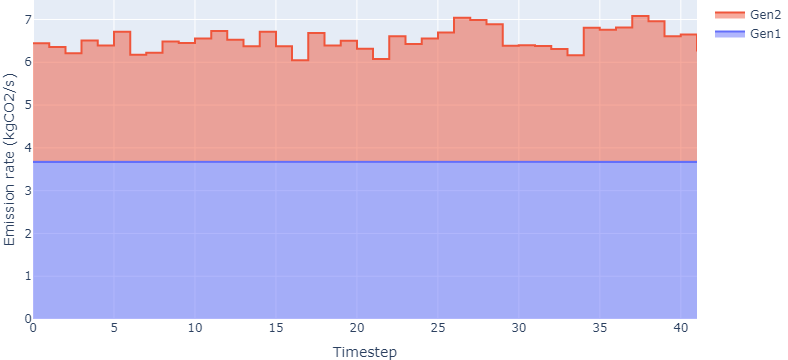

In [48]:
plots.plotter="plotly"
fig=plots.plot_CO2rate_per_dev(simulator,reverseLegend=True,filename=outpath+"co2rate_opt.png")
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

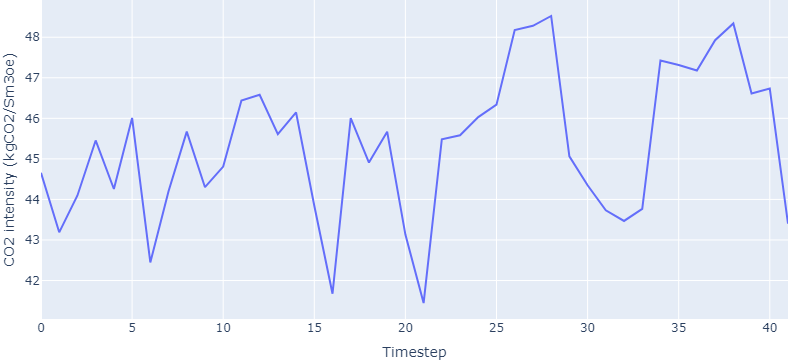

In [49]:
fig=plots.plot_CO2_intensity(simulator,filename=outpath+"co2intensity_opt.png")
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=0,b=0))

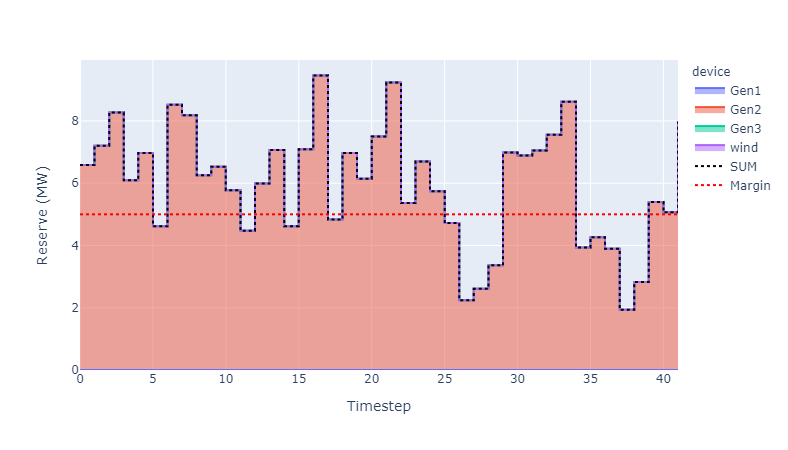

In [50]:
plots.plotReserve(simulator,dynamicMargin=True)

In [51]:
# This plot shows per device its output (dotted line) and the available online backup, iel reserve 
# by _other_ devices (solid line). MARGIN(t) = min_devices(backup(t) - output(t))
#plots.plotElBackup(mc,showMargin=True,returnMargin=False)